<a href="https://colab.research.google.com/github/GRodrigues4/EVM-and-Deep-Learning-for-Remote-HR-Estimation/blob/main/EVM_HR_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages

In [ ]:
# Install all the needed packages
!pip install mediapipe

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

  Using cached mediapipe-0.10.14-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
  Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached protobuf-4.25.4-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached sounddevice-0.5.0-py3-none-any.whl.metadata (1.4 kB)
Using cached mediapipe-0.10.14-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.7 MB)
Using cached protobuf-4.25.4-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached sounddevice-0.5.0-py3-none-any.whl (32 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the f

In [ ]:
# Import all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import scipy.fftpack as fftpack
import scipy.signal as signal
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [ ]:
# Give access to the dataset
from google.colab import drive
drive.mount('/content/drive')

# Import the Mediapipe model
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset


### Video/Signal Processing

In [ ]:
class SignalProcessing:
  def __init__(self, file, time_stamps = [], split_time = 20, sample_rate = 1000):

    # Constructor to initialize the SignalProcessing class with parameters:
    # file: The file name containing the data.
    # time_stamps: A list of timestamps to be skipped.
    # split_time: The duration (in seconds) for which HR is calculated (each interval).
    # sample_rate: The rate at which data is sampled, in Hz (samples per second).

    self.file_name = file
    self.time_stamps = time_stamps
    self.split_time = split_time
    self.sample_rate = sample_rate


  def cut(self):

    # Method to preprocess the data by selecting a portion of the ECG signal
    # based on the condition that there is no '1' found in a specific range of 'In' values.
    # Returns the preprocessed ECG and Input (button for sync) signals.

    data = np.loadtxt(self.file_name) # Load the data from the file.
    ECG = []  # Initialize an empty list to store ECG signal values.
    In = []   # Initialize an empty list to store 'In' signal values.

    # Iterate through each row in the data.
    for row in data:
      ECG.append(row[5])  # Append the 6th column (ECG) to the ECG list.
      In.append(row[1])   # Append the 2nd column (In) to the In list.

    # Iterate through ECG data in steps of 100.
    for index in range(0,len(ECG),100):
      # Check if there is no '1' in the 'In' signal within the specified range.
      if not any(element == 1 for element in In[index:(index+60*self.sample_rate)]):
        # Select the ECG and In data for the next 10 minutes (600 seconds).
        ECG = ECG[index:(index+60*10*self.sample_rate)]
        In = In[index:(index+60*10*self.sample_rate)]
        break # Exit the loop once the desired segment is found.

    return ECG, In


  def meanHR(self, ECG):

    # Method to calculate the mean heart rate (HR) from the ECG signal.
    # Returns the mean HR value.

    ECG = np.array(ECG)       # Convert the ECG list to a NumPy array.
    ECG = ECG - np.mean(ECG)  # Detrend the ECG signal by subtracting the mean.
    ECG = (ECG/np.max(ECG))   # Normalize the ECG signal to the range [0, 1].

    ECG[ECG < 0.4] = 0  # Apply a threshold to eliminate low-amplitude noise.
    distance = 0.4*self.sample_rate   # Minimum distance between peaks.

    # Detect peaks in the ECG signal.
    peaks, _ = signal.find_peaks(ECG, distance=distance)

    # Calculate the RR intervals (time difference between successive peaks).
    rr_intervals = np.diff(peaks)/self.sample_rate

    # Calculate heart rate in beats per minute (BPM).
    heart_rate = 60 / rr_intervals

    # Calculate and return the mean HR rounded to the nearest integer.
    mean_hr = round(np.mean(heart_rate))

    return int(mean_hr)


  def save(self, array, name):

    # Method to save the calculated HR values to a text file.
    # Takes the HR values and the desired file name as parameters.
    # The HR values are saved in a format suitable for further analysis.

    # Save the array with HR values to a text file, along with a descriptive header.
    np.savetxt(name, array, fmt='%i', delimiter='\t', header='Mean Heart Rate (HR) of each interval video, calculated using'
      + ' the time difference between R-R peaks. Each value corresponds to an interval of ' + str(self.split_time)
               + ' seconds of the respective subject (i.e. the interval with index 0 corresponds to the mean HR between 0 and'
               +  str(self.split_time) + 'seconds of recording and so on).\nThis file is in a format appropriate to read with '
               + 'Python NumPy "loadtxt" function.\nThe left values correspond to the index of the interval and the right '
               + 'column has the values of the measured mean HR. In case of 0 value it means the interval was removed due '
               + 'to severe artifacts of image/signal.\n\tHR')


  def run(self, output_file = "output_file.txt"):

    # Method to run the complete processing pipeline: cutting the data, calculating HR, and saving the results.

    ECG, In = self.cut()  # Cut and preprocess the data.
    HR_values = []        # Initialize a list to store the HR values for each interval.
    time = self.split_time*self.sample_rate   # Calculate the number of samples in each interval.

    # Generate a list of indexes corresponding to the given timestamps.
    indexes = [((index*self.sample_rate)//time)*time for index in self.time_stamps]

    # Iterate through the ECG signal in steps of 'time' (one interval at a time).
    for i in range(0, len(ECG), time):
      if i in indexes:    # Check if the current interval should be skipped.
        HR_values.append([i//time,0])   # Append a zero HR value for skipped intervals.
      else:
        # Calculate and append the mean HR for the current interval.
        HR_values.append([i//time,self.meanHR(ECG[i:i+time])])

    self.save(HR_values, output_file) # Save the HR values to the output file.

In [ ]:
class VideoSegmentation:
  def __init__(self, file_path, time_stamps = [], split_time = 20, fps = 30, image_width = 1280,
               image_height = 720, bounding_box_size = 64):

    # Constructor to initialize the VideoSegmentation class with parameters:
    # file_path: Path to the video file.
    # time_stamps: List of timestamps to skip.
    # split_time: Duration (in seconds) for segmenting the video into intervals.
    # fps: Frames per second of the video.
    # image_width: Width of the video frame in pixels.
    # image_height: Height of the video frame in pixels.
    # bounding_box_size: Size of the bounding box around facial landmarks.

    self.file_path = file_path
    self.time_stamps = time_stamps
    self.split_time = split_time
    self.fps = fps
    self.image_width = image_width
    self.image_height = image_height
    self.box_size = bounding_box_size


  def relative_to_absolute(self, relative_coords):

    # Convert relative coordinates (normalized between 0 and 1) to absolute pixel values.
    # Returns a list of absolute coordinates.

    absolute_coords = [[int(coord[0] * self.image_width), int(coord[1] * self.image_height)] for coord in relative_coords]

    return absolute_coords


  def segment_frame(self, frame, time_ms):

    # Method to detect facial landmarks in the given frame and return the coordinates of specific landmarks.
    # Returns a list of relative coordinates for the specified landmarks.

    # Create a face landmarker instance with the video mode in order to extract the facial features
    base_options = python.BaseOptions(model_asset_path = 'face_landmarker_v2_with_blendshapes.task')
    options = vision.FaceLandmarkerOptions(base_options = base_options, running_mode = mp.tasks.vision.RunningMode.VIDEO)
    detector = vision.FaceLandmarker.create_from_options(options)

    # Convert the frame to RGB as the model expects RGB input.
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

    # Detect facial landmarks for the frame at the given time in milliseconds.
    result = detector.detect_for_video(mp_image, round(time_ms))

    # Extract specific landmark coordinates: forehead, cheek 1, and cheek 2.
    coord = [(result.face_landmarks[0][151].x, result.face_landmarks[0][151].y),(result.face_landmarks[0][50].x, result.face_landmarks[0][50].y)
          ,(result.face_landmarks[0][280].x, result.face_landmarks[0][280].y)]
    coord = self.relative_to_absolute(coord)

    return coord


  def create_bounding_box(self, coord):

    # Method to create a bounding box around a given coordinate.
    # Returns the top-left and bottom-right coordinates of the bounding box.

    x_coord = coord[0]
    y_coord = coord[1]

    # Calculate the bounding box limits ensuring they stay within frame boundaries.
    x_min = max(0, x_coord - self.box_size // 2)
    y_min = max(0, y_coord - self.box_size // 2)
    x_max = min(self.image_width, x_coord + self.box_size // 2)
    y_max = min(self.image_height, y_coord + self.box_size // 2)

    return (int(x_min), int(y_min)), (int(x_max), int(y_max))


  def cut_video(self, frame, coord):

    # Method to extract a specific segment of the video frame using a bounding box.
    # Returns the segmented frame.

    top_left, bottom_right = self.create_bounding_box(coord)
    segmented_frame = frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    return segmented_frame


  def save_video(self, video, output_path):

    # Method to save the segmented video frames to a file.
    # Takes the segmented frames and the desired output file path as parameters.

    # Define the codec and create a VideoWriter object.
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    [image_height, image_width] = video[0].shape[0:2]
    writer = cv2.VideoWriter(output_path, fourcc, self.fps, (image_width, image_height), 1)

    # Write each frame to the output video.
    for i in range(video.shape[0]):
        writer.write(cv2.convertScaleAbs(video[i]))
    writer.release()


  def run(self, output_path = "output_video"):

    # Method to execute the complete video segmentation process and save the results.

    # Open the video file using OpenCV.
    cap = cv2.VideoCapture(self.file_path)
    if not cap.isOpened():
      raise ValueError("Error opening video file")

    i = 0     # Initialize frame index.
    interval_video_F = []   # List to store segmented frames for the forehead.
    interval_video_C1 = []  # List to store segmented frames for the first cheek.
    interval_video_C2 = []  # List to store segmented frames for the second cheek.

    # Convert timestamps to frame indexes.
    indexes = [index//self.split_time for index in self.time_stamps]

    # Process each frame of the video.
    while cap.isOpened():
      ret, frame = cap.read()
      time_ms = cap.get(cv2.CAP_PROP_POS_MSEC)  # Get the current frame timestamp in milliseconds.

      # Check if the video has ended.
      if not ret:
        raise ValueError("Error reading frame")
        break

      if i not in indexes:
        # Resize the frame if its dimensions don't match the expected ones.
        if int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) != self.image_height:
          frame = cv2.resize(frame, (self.image_width, self.image_height))
        try:
          # Detect and get facial landmark coordinates.
          coordinates = self.segment_frame(frame, time_ms)
        except IndexError as e:
          print(f"{e}: No face detected at frame {cap.get(cv2.CAP_PROP_POS_FRAMES)}")
          cv2_imshow(frame)   # Display the frame where the face was not detected.
          break

        # Segment and store the video frames for each region (forehead, cheek 1, cheek 2).
        interval_video_F.append(self.cut_video(frame, coordinates[0]))
        interval_video_C1.append(self.cut_video(frame, coordinates[1]))
        interval_video_C2.append(self.cut_video(frame, coordinates[2]))

      # Save the segmented videos after processing each interval.
      if len(interval_video_F) == self.split_time*self.fps:
        self.save_video(np.array(interval_video_F), output_path + '_Forehead_' + str(i) + '.avi')
        self.save_video(np.array(interval_video_C1), output_path + '_Cheek1_' + str(i) + '.avi')
        self.save_video(np.array(interval_video_C2), output_path + '_Cheek2_' + str(i) + '.avi')
        interval_video_F = []   # Reset the lists after saving.
        interval_video_C1 = []
        interval_video_C2 = []

      # Update the frame index.
      i = int(cap.get(cv2.CAP_PROP_POS_FRAMES)//(self.fps*self.split_time))

      # Print the progress for every 1000th frame.
      if cap.get(cv2.CAP_PROP_POS_FRAMES) % 1000 == 0:
        print(f"Frame {cap.get(cv2.CAP_PROP_POS_FRAMES)}")

      # Break the loop if the video exceeds 10 minutes.
      if cap.get(cv2.CAP_PROP_POS_FRAMES) == (self.fps*60*10):
        break

    print(output_path + '. . . . . . . Done\n')

    # Release the video capture and close any OpenCV windows.
    cap.release()
    cv2.destroyAllWindows()

### Create Dataset

In [ ]:
def CreateDataset(array_like):

  # Function that applies both the Video and Signal processing on the raw dataset.
  # Saves the interval videos and a txt file with the HR groundtruth.

  # Iterate through the given list.
  for i, time in array_like:
    in_path = '/content/drive/My Drive/Data Tese/Subject_' + str(i) + '/Subject_' + str(i)  # Define file paths.
    out_path = '/content/drive/My Drive/Dataset/Subject_' + str(i) + '/Subject_' + str(i)

    # Apply image and signal processing functions defined previously
    SignalProcessing(in_path + '.txt', time_stamps = time).run(output_file = out_path + '_HR.txt')
    #VideoSegmentation(in_path + '.mp4', time_stamps = time).run(output_path = out_path + '_')

# Create a list where each component is a subsequent list with the subject number and time stamps to be removed.
# This list represents the approach used for the original dataset used with this algorithm
# and the timestamps here represent areas of the video/ECG with severe artifacts that the face detection or HR estimation could not handle.
# Since a timestamp is composed of 20 seconds, any frame within this 20 seconds makes it skip the interval as a whole.
# The number of the frames used are arbitrary numbers within the intervals that had to be removed
# A list of all "possible" time stamps can be seen here: [10,30,50,70,90,110,130,150,170,190,210,230,250,270,290,310,330,350,370,390,410,430,450,470,490,510,530,550,570,590],
# to a total of 30 intervals (30 * 20s = 600s = 10min).
List = [[1,[]],[2,[470]],[3,[30,110,130,230]],[4,[30,50,190,210,250,290,570]],[5,[430]],[6,[]],[7,[]],[8,[]],[9,[]],[10,[10]],[11,[10]], [12,[]], [13,[10]]
         , [14,[]], [15,[370,450,550,590]], [16,[]], [17,[]], [18,[370,430]], [19,[]], [20,[]], [21,[310,570,590]], [22,[]], [23,[]], [24,[]], [25,[]], [26,[]], [27,[50]]]

CreateDataset(List)

# Heart Rate Predictiom

### Magnification

In [ ]:
class EVM:
  def __init__(self, video_path, freq = [0.7, 2.5], amplification = 75, pyramid_level = 7, fps = 30):

    # Constructor to initialize the EVM class with parameters:
    # video_path: Path to the input video file.
    # freq: Tuple containing the lower and upper frequency bounds (in Hz) for bandpass filtering.
    # amplification: Amplification factor to apply to the filtered signal.
    # pyramid_level: Number of levels in the Gaussian pyramid.
    # fps: Frames per second of the video.

    self.video_path = video_path
    self.freq_low = freq[0]
    self.freq_high = freq[1]
    self.amp = amplification
    self.levels = pyramid_level
    self.fps = fps


  def fft_filter(self, video):

    # Apply FFT to the video, filter it based on frequency bounds, and amplify the result.
    # Returns the filtered video.

    # Perform FFT along the time axis (axis=0).
    fft = fftpack.rfft(video, axis=0)

    # Get the frequency spectrum corresponding to the FFT.
    frequencies = fftpack.rfftfreq(fft.shape[0], d=1.0 / self.fps)

    # Create a mask to keep only the frequencies within the specified range.
    mask = np.logical_and(frequencies > self.freq_low, frequencies < self.freq_high)

    # Zero out the frequencies outside the specified range.
    fft[~mask] = 0

    # Perform inverse FFT to get the filtered video.
    filtered = fftpack.irfft(fft, axis=0)

    # Amplify the filtered signal.
    filtered *= self.amp

    return filtered


  def load_video(self, video_path):

    # Load the video from the specified path and store its frames in a NumPy array.
    # Returns the video frames.

    cap = cv2.VideoCapture(video_path)

    # Check if the video file opened successfully.
    if not cap.isOpened():
      raise ValueError("Error opening video file")

    # Get the number of frames, width, and height of the video.
    len = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    image_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    image_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create an empty array to store the video frames.
    video_frames = np.empty((len, image_height, image_width, 3))

    # Read each frame and convert it from BGR (OpenCV format) to RGB.
    for x in range(len):
      ret, frame = cap.read()
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      video_frames[x] = frame

      # Check if there was an error reading the frame.
      if not ret:
        raise ValueError("Error reading frame")
        break

    # Release the video capture object.
    cap.release()

    return video_frames


  def rgb2yiq(self, video):

    # Convert the video from RGB color space to YIQ color space.

    yiq_from_rgb = np.array([[0.299, 0.587, 0.114],
                            [0.596, -0.274, -0.322],
                            [0.211, -0.523, 0.312]])

    # Apply the RGB to YIQ conversion matrix.
    t = np.dot(video, yiq_from_rgb.T)

    return t


  def yiq2rgb(self, video):

    # Convert the video from YIQ color space back to RGB color space.

    rgb_from_yiq = np.array([[1, 0.956, 0.621],
                            [1, -0.272, -0.647],
                            [1, -1.106, 1.703]])

    # Apply the YIQ to RGB conversion matrix.
    t = np.dot(video, rgb_from_yiq.T)

    return t


  def create_gaussian_pyramid(self, image, levels):

    # Create a Gaussian pyramid with the specified number of levels for the given image.

    gauss = image.copy()
    gauss_pyr = [gauss]

    # Iteratively downsample the image to create the pyramid.
    for level in range(1, levels):
      gauss = cv2.pyrDown(gauss)
      gauss_pyr.append(gauss)

    return gauss_pyr


  def gaussian_video(self, video):

    # Apply a Gaussian pyramid to each frame of the video and extract the smallest level.
    # Returns the Gaussian video.

    for i in range(0, video.shape[0]):
      frame = video[i]
      pyr = self.create_gaussian_pyramid(frame, self.levels)
      gaussian_frame = pyr[-1]    # Use the smallest level of the pyramid.

      # Initialize the array to store the Gaussian video if it's the first frame.
      if i == 0:
        gaussian_video = np.zeros((video.shape[0], gaussian_frame.shape[0], gaussian_frame.shape[1], 3))

      gaussian_video[i] = gaussian_frame

    return gaussian_video


  def run(self):

    # Main method to execute the Eulerian Video Magnification process.
    # Returns the filtered video.

    # Load the video.
    video = self.load_video(self.video_path)

    # Convert the video to YIQ color space.
    video = self.rgb2yiq(video)

    # Apply a Gaussian pyramid to the video.
    gaussian_video = self.gaussian_video(video)

    # Apply the FFT-based filter to the Gaussian video.
    filtered = self.fft_filter(gaussian_video)

    # Convert the filtered video back to RGB color space.
    filtered_video = self.yiq2rgb(filtered)

    # Normalize the pixel values to ensure they are in [0,1] range for the DL model.
    filtered_video[filtered_video < 0] = 0
    filtered_video = (filtered_video/np.max(filtered_video))

    return filtered_video

### Helper Functions

In [ ]:
class DataPreparation(Dataset):
  def __init__(self, subjects, videos, heart_rates):

    # Constructor to initialize the dataset with the provided data.
    # subjects: List or array of subject identifiers.
    # videos: List or array of video data, where each element corresponds to a subject.
    # heart_rates: List or array of heart rate data, where each element corresponds to a subject.

    self.subjects = subjects
    self.videos = videos
    self.heart_rates = heart_rates


  def __len__(self):

    # Returns the total number of samples in the dataset.

    return len(self.subjects)

  def __getitem__(self, idx):

    # Returns the video and heart rate data at the specified index.

    video = self.videos[idx]    # Get the video data at the given index.
    heart_rate = self.heart_rates[idx]  # Get the heart rate data at the given index.

    # Convert the heart rate data to a torch tensor of type float32.
    return video, torch.tensor(heart_rate, dtype=torch.float32)


class EarlyStopping:
  def __init__(self, patience=5, min_delta=0):

    # Constructor to initialize the early stopping mechanism.
    # patience: Number of epochs to wait after the last improvement before stopping.
    # min_delta: Minimum change in the monitored quantity to qualify as an improvement.

    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0    # Counter to track the number of epochs without improvement.
    self.best_loss = None    # Best loss value observed so far.
    self.early_stop = False    # Flag to indicate if early stopping should be triggered.

  def __call__(self, val_loss):

    # Method to be called at each epoch to check whether early stopping should be triggered.

    # Initialize best_loss if it hasn't been set yet
    if self.best_loss is None:
      self.best_loss = val_loss
    # Check if validation loss has increased more than min_delta
    elif val_loss > self.best_loss + self.min_delta:
      self.counter += 1   # Increment the counter if no improvement is observed.
      # If counter exceeds patience, set early_stop to True
      if self.counter >= self.patience:
        self.early_stop = True
    else:
      # If there is an improvement, update the best_loss and reset the counter.
      self.best_loss = val_loss
      self.counter = 0

### Data Split

In [ ]:
num_subjects = 27   # Total number of subjects in the dataset.
#videos = []        # List to store video data (commented out).
subject_num = []    # List to store subject numbers.
heart_rate = []     # List to store corresponding heart rate values.
interval = []       # List to store the interval indices for each subject.

# Loop over each subject's interval videos and txt files to process their data.
for i in range(1, num_subjects+1):
  # Load the heart rate information for the current subject.
  info = np.loadtxt('/content/drive/My Drive/Dataset/Subject_'+ str(i) +'/Subject_' + str(i) + '_HR.txt')

  # Loop over each entry in the heart rate info.
  for j in range(len(info)):
    if info[j][1] != 0:   # Only consider intervals where the heart rate is not zero
      #video = EVM('/content/drive/My Drive/Dataset/Subject_'+ str(i) +'/Subject_' + str(i) + '__Forehead_' + str(j) + '.avi').run()
      #video = np.transpose(video, (3, 0, 1, 2))
      #videos.append(torch.tensor(video, dtype=torch.float32))

      # Append subject number, heart rate, and interval index to their respective lists.
      subject_num.append(i)
      heart_rate.append(info[j][1])
      interval.append(info[j][0])
  print("Subject " + str(i) + " is done")   # Print a message when processing for a subject is completed.

# Save the processed video data (commented out).
#np.save("videos.npy", videos)

# Load the saved video data.
videos = np.load("videos.npy")
videos = np.array(videos)   # Convert the list of videos to a NumPy array.

# Split the dataset into training and temporary sets (40% of the data is reserved for validation and testing).
subject_num_train, subject_num_temp, videos_train, videos_temp, heart_rate_train, heart_rate_temp = train_test_split(
    subject_num, videos, heart_rate, test_size=0.4, random_state=42, stratify=subject_num)

# Further split the temporary set into validation and test sets (40% of the temp set, which is 16% of the total data).
subject_num_val, subject_num_test, videos_val, videos_test, heart_rate_val, heart_rate_test = train_test_split(
    subject_num_temp, videos_temp, heart_rate_temp, test_size=0.4, random_state=42, stratify=subject_num_temp)

# Create dataset instances for training, validation, and testing.
train_dataset = DataPreparation(subject_num_train, videos_train, heart_rate_train)
val_dataset = DataPreparation(subject_num_val, videos_val, heart_rate_val)
test_dataset = DataPreparation(subject_num_test, videos_test, heart_rate_test)

# Create data loaders for batching and shuffling the datasets.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Subject 1 is done
Subject 2 is done
Subject 3 is done
Subject 4 is done
Subject 5 is done
Subject 6 is done
Subject 7 is done
Subject 8 is done
Subject 9 is done
Subject 10 is done
Subject 11 is done
Subject 12 is done
Subject 13 is done
Subject 14 is done
Subject 15 is done
Subject 16 is done
Subject 17 is done
Subject 18 is done
Subject 19 is done
Subject 20 is done
Subject 21 is done
Subject 22 is done
Subject 23 is done
Subject 24 is done
Subject 25 is done
Subject 26 is done
Subject 27 is done


In [ ]:
# Develop a baseline method to evaluate the Deep Learning Network performance.

# Extract the green channel (second channel) from the video data for all samples.
data = videos[:,1:2,:,:,:]

# Reshape the data to collapse the spatial dimensions (width and height) into a single dimension.
data = data.reshape(data.shape[0], -1)

result = []   # List to store the estimated heart rates for each video.

# Loop over each video in the dataset.
for vid in data:
  # Detect peaks in the green channel signal; 'distance=14' ensures that peaks are not too close together.
  peaks, _ = signal.find_peaks(vid, distance=14)

  # Calculate the time intervals (in seconds) between consecutive peaks (RR intervals).
  rr_intervals = np.diff(peaks)/30    # Assuming a frame rate of 30 FPS.

  # Calculate heart rates (beats per minute) based on RR intervals.
  hearts = 60 / rr_intervals

  # Compute the mean heart rate for the video and round it to the nearest integer.
  mean_hr = round(np.mean(hearts))

  # Append the estimated mean heart rate to the results list.
  result.append(mean_hr)

# Initialize error metrics: Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE).
MAE = 0
MAPE = 0
RMSE = 0

# Calculate the error metrics.
for i in range(len(heart_rate)):

  # Compute the absolute difference between the estimated and true heart rates.
  MAE += abs(result[i] - heart_rate[i])

  # Compute the absolute percentage error.
  MAPE += abs(result[i] - heart_rate[i])/heart_rate[i]

  # Compute the squared error.
  RMSE += (result[i] - heart_rate[i])**2

# Average the MAE over the videos.
MAE = MAE/len(heart_rate)

# Average the MAPE over the videos and convert it to a percentage.
MAPE = (MAPE/len(heart_rate))*100

# Calculate the RMSE by taking the square root of the average squared error.
RMSE = np.sqrt(RMSE/len(heart_rate))

# Print the calculated error metrics.
print("MAE:", MAE)
print("MAPE:", MAPE)
print("RMSE:", RMSE)

MAE: 6.769132653061225
MAPE: 8.456119732871342
RMSE: 9.941987338801933


In [ ]:
# Print all the predictions and respective ground truth to check for data inconsistencies
# and/or errors during the ground truth calculation.

for i in range(len(result)):
  print("Real:", heart_rate[i], "- Predicted:", result[i], "\t..... Subject/Interval:", subject_num[i], int(interval[i]))

Real: 62.0 - Predicted: 63 	..... Subject/Interval: 1 0
Real: 60.0 - Predicted: 61 	..... Subject/Interval: 1 1
Real: 59.0 - Predicted: 60 	..... Subject/Interval: 1 2
Real: 59.0 - Predicted: 60 	..... Subject/Interval: 1 3
Real: 59.0 - Predicted: 59 	..... Subject/Interval: 1 4
Real: 59.0 - Predicted: 60 	..... Subject/Interval: 1 5
Real: 57.0 - Predicted: 61 	..... Subject/Interval: 1 6
Real: 62.0 - Predicted: 63 	..... Subject/Interval: 1 7
Real: 61.0 - Predicted: 64 	..... Subject/Interval: 1 8
Real: 59.0 - Predicted: 60 	..... Subject/Interval: 1 9
Real: 58.0 - Predicted: 59 	..... Subject/Interval: 1 10
Real: 58.0 - Predicted: 59 	..... Subject/Interval: 1 11
Real: 60.0 - Predicted: 60 	..... Subject/Interval: 1 12
Real: 62.0 - Predicted: 65 	..... Subject/Interval: 1 13
Real: 59.0 - Predicted: 60 	..... Subject/Interval: 1 14
Real: 52.0 - Predicted: 53 	..... Subject/Interval: 1 15
Real: 53.0 - Predicted: 54 	..... Subject/Interval: 1 16
Real: 53.0 - Predicted: 54 	..... Subject

### Model Architecture

In [ ]:
class TemporalCNN(nn.Module):
  def __init__(self):
    super(TemporalCNN, self).__init__()

    # Define the first convolutional block
    self.conv11 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=12, padding=1)
    self.conv12 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=1, padding=1)

    # Define the second convolutional block
    self.conv21 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=24, padding=1)
    self.conv22 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=1, padding=1)

    # Define the third convolutional block
    self.conv31 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=24, padding=1)
    self.conv32 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=1, padding=1)

    # Batch normalization layers for each convolutional block
    self.bn1 = nn.BatchNorm1d(8,track_running_stats=False)
    self.bn2 = nn.BatchNorm1d(16,track_running_stats=False)
    self.bn3 = nn.BatchNorm1d(32,track_running_stats=False)

    # Activation function and dropout layer
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    # Apply the first convolutional block followed by batch normalization, ReLU, and dropout
    x = self.bn1(self.conv12(self.conv11(x)))
    x = self.relu(x)
    x = self.dropout(x)

    # Apply the second convolutional block followed by batch normalization, ReLU, and dropout
    x = self.bn2(self.conv22(self.conv21(x)))
    x = self.relu(x)
    x = self.dropout(x)

    # Apply the third convolutional block followed by batch normalization, ReLU, and dropout
    x = self.bn3(self.conv32(self.conv31(x)))
    x = self.relu(x)
    x = self.dropout(x)

    return x


class DenormalizeLayer(nn.Module):
  def __init__(self, original_min=40, original_max=150):
    super(DenormalizeLayer, self).__init__()

    # Define the range to denormalize values back to their original scale
    self.original_min = original_min
    self.original_max = original_max

  def forward(self, x):
    # Convert normalized values back to the original scale
    return x * (self.original_max - self.original_min) + self.original_min


class CombinedModel(nn.Module):
  def __init__(self):
    super(CombinedModel, self).__init__()

    # Initialize the temporal CNN and LSTM layers
    self.temporal_cnn = TemporalCNN()
    self.lstm = nn.LSTM(input_size=32*1*1, hidden_size=128, batch_first=True)

    # Fully connected (dense) layers with batch normalization and activation functions
    self.fc1 = nn.Linear(128, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 1)

    self.bn1 = nn.BatchNorm1d(64,track_running_stats=False)
    self.bn2 = nn.BatchNorm1d(32,track_running_stats=False)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(0.5)
    self.denormalize = DenormalizeLayer()

    # Initialize weights
    self.initialize_weights()

  def forward(self, x):

    # Reshape the input to match the expected shape of (batch_size, channels, time)
    batch_size, c, t, h, w = x.shape
    x = x.view(batch_size, c, t)

    # Pass the data through the TemporalCNN
    x = self.temporal_cnn(x)

    # Reshape the output to match the input size of the LSTM
    x = x.view(batch_size, 555, 32)

    # Pass the data through the LSTM
    lstm_out, _ = self.lstm(x)

    # Use the output from the last time step of the LSTM
    x = lstm_out[:, -1, :]

    # Pass through fully connected layers with batch normalization, ReLU, and dropout
    x = self.bn1(self.fc1(x))
    x = self.relu(x)
    x = self.dropout(x)

    x = self.bn2(self.fc2(x))
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc3(x)

    # Apply sigmoid activation function and denormalize the output
    x = self.sigmoid(x)
    x = self.denormalize(x)

    return x.squeeze()


  def initialize_weights(self):

    # Initialize weights for Conv1d, Linear, and LSTM layers

    for m in self.modules():
      if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
          if 'weight_ih' in name:
            nn.init.xavier_uniform_(param.data)
          elif 'weight_hh' in name:
            nn.init.orthogonal_(param.data)
          elif 'bias' in name:
            param.data.fill_(0)

### Model Training

In [ ]:
# Initialize the Model.
model = CombinedModel()

# Determine the device to use (GPU if available, otherwise CPU).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss function, optimizer, and early stopping criteria.
criterion = nn.MSELoss() # Mean Squared Error Loss for regression tasks.
optimizer = optim.Adam(model.parameters(), lr=0.001)    # Adam optimizer for training.
early_stopping = EarlyStopping(patience=20, min_delta=0.1)    # Early stopping to prevent overfitting.

# Set the number of training epochs.
num_epochs = 1000
# Move model to the specified device (GPU or CPU).
model = model.to(device)

# Lists to store training and validation loss for plotting.
loss_train_plot = []
loss_val_plot = []

#Model Training.
for epoch in range(num_epochs):
  model.train()   # Set the model to training mode.
  running_loss = 0.0    # Initialize running loss for this epoch.

  # Iterate over training data.
  for videos, scalars in train_loader:
    videos, scalars = videos.to(device), scalars.to(device)   # Move data to device.
    optimizer.zero_grad()   # Zero the parameter gradients.
    outputs = model(videos)   # Forward pass.
    loss = criterion(outputs, scalars)    # Compute loss.
    loss.backward()   # Backward pass.
    optimizer.step()    # Update weights.
    running_loss += loss.item()   # Accumulate loss.

  # Compute average training loss for this epoch.
  train_loss = running_loss / len(train_loader)
  loss_train_plot.append(train_loss)    # Store for plotting .

  # Evaluate the model on the validation set.
  model.eval()    # Set the model to evaluation mode.
  val_loss = 0.0
  previous = 100    # Initialize previous validation loss for early stopping.

  with torch.no_grad():   # No need to compute gradients for validation.
    for videos, scalars in val_loader:
      videos, scalars = videos.to(device), scalars.to(device)   # Move data to device.
      outputs = model(videos)   # Forward pass
      loss_val = criterion(outputs, scalars)    # Compute validation loss.
      val_loss += loss_val.item()   # Accumulate validation loss.

  # Compute average validation loss for the epoch.
  val_loss_final = val_loss / len(val_loader)
  loss_val_plot.append(val_loss_final)    # Store for plotting.

  # Print training and validation loss for the epoch.
  print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss_final:.3f}')
  torch.cuda.empty_cache()    # Clear GPU memory

  # Update best model if validation loss improves.
  if val_loss_final < previous:
    previous = val_loss_final
    best_model = model.state_dict()

  # Check for early stopping.
  early_stopping(val_loss)
  if early_stopping.early_stop:
    print("Early stopping triggered")
    break

# Save the best model to a file.
torch.save(best_model, 'best-model.pt')
# Load the best model weights.
model.load_state_dict(torch.load('best-model.pt'))

# Evaluation on the test set.
model.eval()    # Set the model to evaluation mode.
test_loss = 0.0
MAE = []    # List to store Mean Absolute Error values.
MAPE = []   # List to store Mean Absolute Percentage Error values.
RMSE = []   # List to store Root Mean Squared Error values.

with torch.no_grad():   # No need to compute gradients for testing.
  for videos, scalars in test_loader:
    videos, scalars = videos.to(device), scalars.to(device)   # Move data to device.
    outputs = model(videos)   # Forward pass.
    loss = criterion(outputs, scalars)    # Compute test loss.
    test_loss += loss.item()    # Accumulate test loss.

    # Calculate metrics for each sample in the test set.
    for pred, value in zip(outputs, scalars):
      pred_flat = pred.view(-1).cpu().numpy()   # Flatten and move to CPU.
      value_flat = value.view(-1).cpu().numpy()  # Flatten and move to CPU.

      MAE.append(abs(pred_flat - value_flat))    # Mean Absolute Error.
      MAPE.append(abs(pred_flat - value_flat)/value_flat)   # Mean Absolute Percentage Error.
      RMSE.append((pred_flat - value_flat)**2)   # Root Mean Squared Error.

# Compute average test loss and metrics.
test_loss = test_loss / len(test_loader)
test_MAE = np.mean(MAE)
test_MAPE = np.mean(MAPE)*100
test_RMSE = np.sqrt(np.mean(RMSE))

# Print test metrics.
print(f'Test Loss: {test_loss:.3f}, Test MAE: {test_MAE:.3f}, Test MAPE: {test_MAPE:.3f},  Test RMSE: {test_RMSE:.3f}')

Epoch 1/1000, Train Loss: 1117.790, Val Loss: 443.027
Epoch 2/1000, Train Loss: 884.314, Val Loss: 269.332
Epoch 3/1000, Train Loss: 739.276, Val Loss: 193.664
Epoch 4/1000, Train Loss: 638.252, Val Loss: 215.112
Epoch 5/1000, Train Loss: 636.156, Val Loss: 259.509
Epoch 6/1000, Train Loss: 542.065, Val Loss: 238.112
Epoch 7/1000, Train Loss: 578.179, Val Loss: 311.512
Epoch 8/1000, Train Loss: 513.175, Val Loss: 308.509
Epoch 9/1000, Train Loss: 509.930, Val Loss: 262.194
Epoch 10/1000, Train Loss: 491.900, Val Loss: 211.339
Epoch 11/1000, Train Loss: 386.748, Val Loss: 189.822
Epoch 12/1000, Train Loss: 389.095, Val Loss: 185.191
Epoch 13/1000, Train Loss: 367.872, Val Loss: 160.700
Epoch 14/1000, Train Loss: 300.028, Val Loss: 145.950
Epoch 15/1000, Train Loss: 299.917, Val Loss: 140.277
Epoch 16/1000, Train Loss: 287.949, Val Loss: 137.971
Epoch 17/1000, Train Loss: 254.282, Val Loss: 130.741
Epoch 18/1000, Train Loss: 266.397, Val Loss: 133.050
Epoch 19/1000, Train Loss: 253.720, 

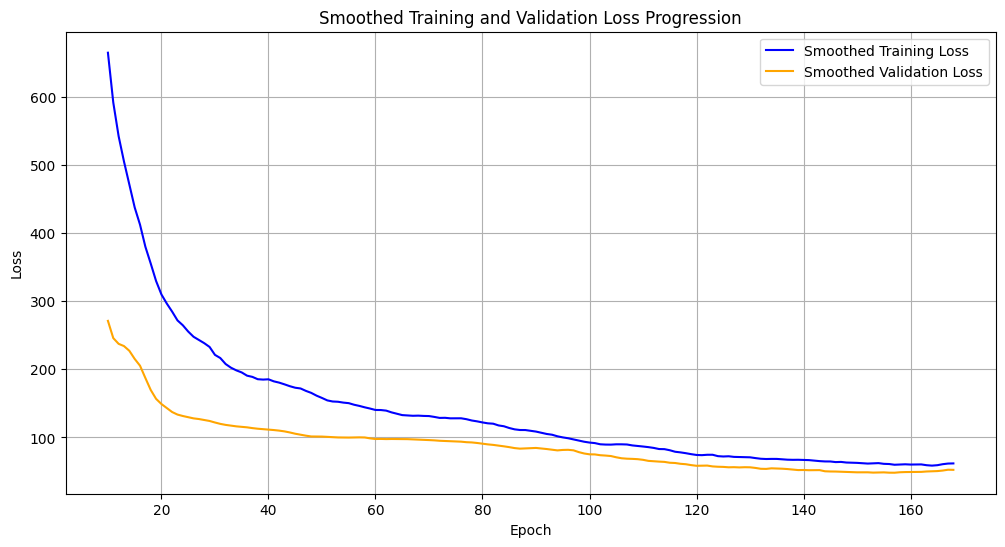

In [ ]:
def moving_average(data, window_size):
    #Compute the moving average of the input data with the given window size.

    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Define the window size for the moving average
window_size = 10

# Calculate moving averages
train_loss_smooth = moving_average(loss_train_plot, window_size)
val_loss_smooth = moving_average(loss_val_plot, window_size)

# Adjust the x-axis range to match the length of the smoothed data
x_axis_train = range(window_size, len(loss_train_plot) + 1)
x_axis_val = range(window_size, len(loss_val_plot) + 1)

# Create a new figure for plotting
plt.figure(figsize=(12, 6))

# Plot smoothed training loss
plt.plot(x_axis_train, train_loss_smooth, label='Smoothed Training Loss', color='blue')

# Plot smoothed validation loss
plt.plot(x_axis_val, val_loss_smooth, label='Smoothed Validation Loss', color='orange')

# Add title and labels
plt.title('Smoothed Training and Validation Loss Progression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()